# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Сначала загрузим пакет LightGBM и импортируем все необходимые библиотеки и инструменты:

In [1]:
! pip install lightgbm
! pip install scikit-learn==1.1.3

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from time import perf_counter

import pylab as pl

Зафиксируем случайное состояение в константе:

In [3]:
RANDOM_STATE = 322

### Загрузка данных и просмотр информации

Загрузим данные в переменную `data` и выведем основную информацию о данных:

In [4]:
data = pd.read_csv('autos.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data.sample(5, random_state=RANDOM_STATE)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
210458,2016-04-06 18:06:31,4200,wagon,2007,manual,0,passat,150000,4,gasoline,volkswagen,no,2016-04-06 00:00:00,0,35606,2016-04-06 18:25:16
246790,2016-03-29 12:41:34,890,small,2000,manual,60,1_reihe,125000,1,petrol,peugeot,no,2016-03-29 00:00:00,0,22145,2016-04-03 20:46:58
124807,2016-03-23 23:56:45,10980,sedan,2009,manual,143,1er,150000,9,gasoline,bmw,no,2016-03-23 00:00:00,0,42399,2016-04-06 19:15:48
139092,2016-03-31 18:42:32,2999,bus,2004,manual,101,zafira,150000,11,petrol,opel,no,2016-03-31 00:00:00,0,38239,2016-04-02 14:15:32
199151,2016-03-05 14:27:53,699,small,1999,manual,55,seicento,150000,3,petrol,fiat,no,2016-03-05 00:00:00,0,60326,2016-03-27 03:45:08


Избавимся от неинформативных столбцов, которые не помогут модели в предсказании.

In [7]:
data = data.drop(['DateCreated', 'LastSeen', 'DateCrawled', 'PostalCode', 'RegistrationMonth'], axis=1)

In [8]:
data.sample(5, random_state=RANDOM_STATE)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,NumberOfPictures
210458,4200,wagon,2007,manual,0,passat,150000,gasoline,volkswagen,no,0
246790,890,small,2000,manual,60,1_reihe,125000,petrol,peugeot,no,0
124807,10980,sedan,2009,manual,143,1er,150000,gasoline,bmw,no,0
139092,2999,bus,2004,manual,101,zafira,150000,petrol,opel,no,0
199151,699,small,1999,manual,55,seicento,150000,petrol,fiat,no,0


Приведём названия столбцов к "lower snake case":

In [9]:
data = data.rename({
    'Price': 'price',
    'VehicleType': 'vehicle_type',
    'RegistrationYear': 'registration_year',
    'Gearbox': 'gearbox',
    'Power': 'power',
    'Model': 'model',
    'Kilometer': 'kilometer',
    'FuelType': 'fuel_type',
    'Brand': 'brand',
    'Repaired': 'repaired',
    'NumberOfPictures': 'number_of_pictures'
}, axis=1)

data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired',
       'number_of_pictures'],
      dtype='object')

### Статистическая информация о данных

Посмотрим статистическую информацию о числовых признаках методом `describe()`:

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
number_of_pictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


По этой таблице можем сделать следующие выводы:  
* Столбец `number_of_pictures` можно удалить, так как в нём только нули.
* В столбце `registration_year` есть некорректные значения: год может лежать в небольшом промежутке от 1900-х годов до 2023 года.
* В столбце `power` также есть некорректные значения: мощность двигателя не может быть нулевой, а также быть очень большой (максимальное значение в таблице 20000).
* Столбцы с ценой и пробегом выглядят адекватно (хотя есть также объекты с нулевой стоимостью).

In [11]:
data = data.drop('number_of_pictures', axis=1)

Создадим списки с названиями непрерывных и категориальных признаков (год выпуска отнесём также к категориальным признакам.

In [12]:
num = ['power', 'kilometer']
cat = list(data.drop(num, axis=1).drop('price', axis=1).columns)

Удалим все объявления "из будущего":

In [13]:
data = data.query('registration_year <= 2023')

Посмотрим на распределение цен и мощностей около нуля:

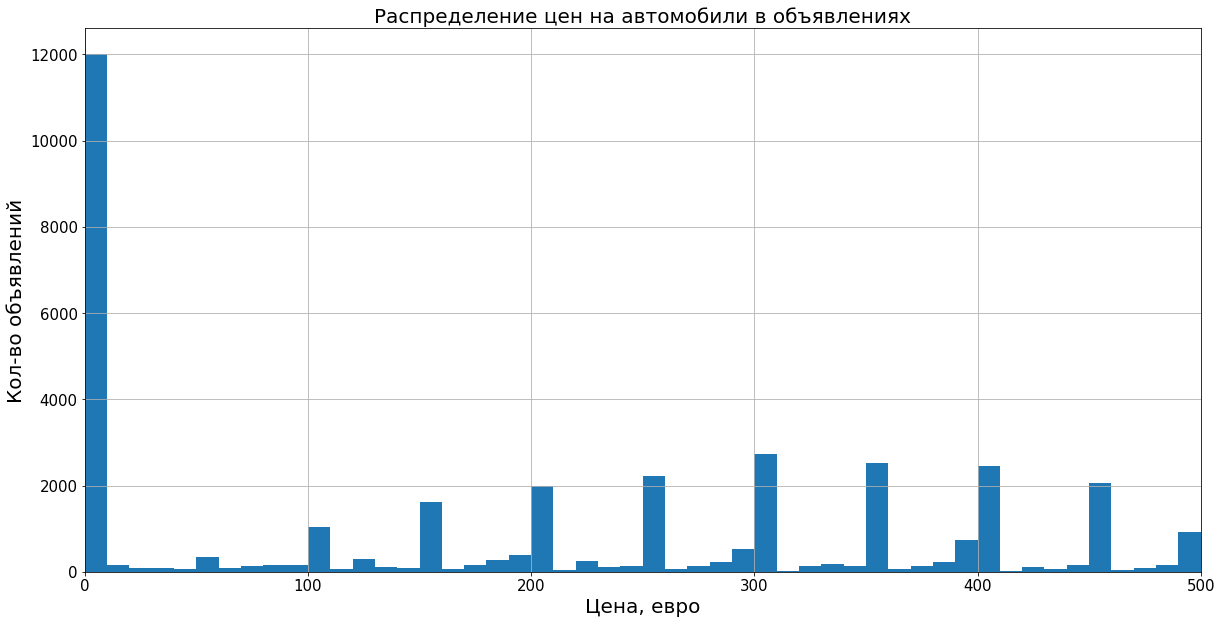

In [14]:
plt.xlim(0, 500)
data['price'].hist(figsize=(20, 10), bins=2000).tick_params(labelsize=15)
plt.ylabel('Кол-во объявлений', fontsize=20)
plt.title('Распределение цен на автомобили в объявлениях', fontsize=20)
plt.xlabel('Цена, евро', fontsize=20);

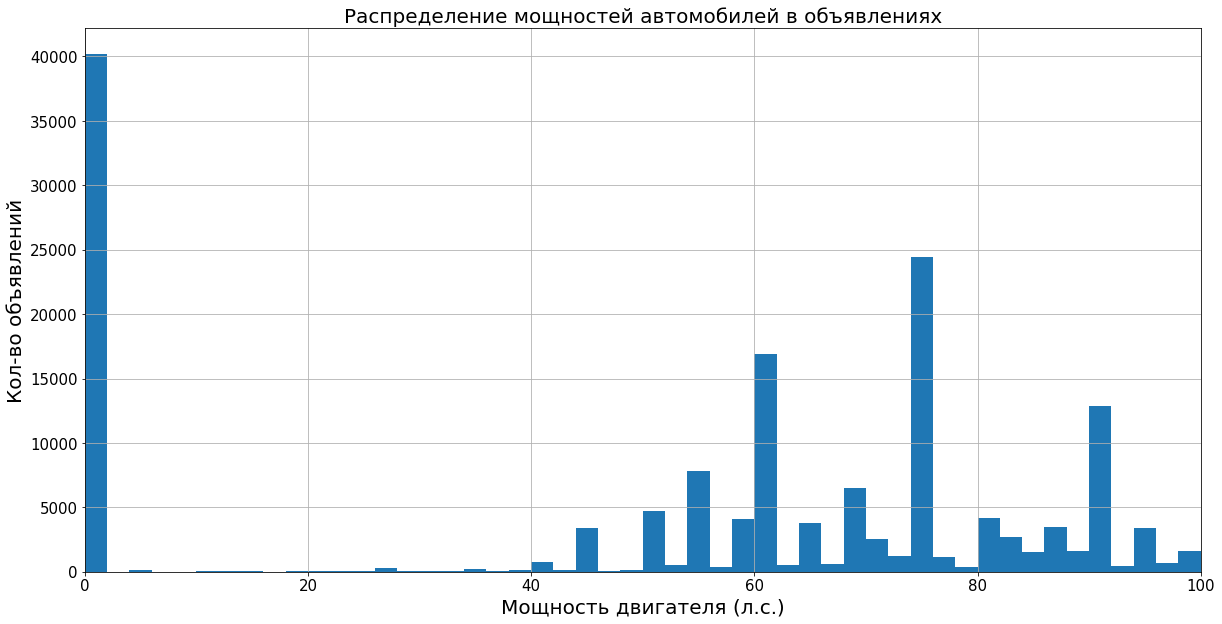

In [15]:
plt.xlim(0, 100)
data['power'].hist(figsize=(20, 10), bins=10000).tick_params(labelsize=15)
plt.ylabel('Кол-во объявлений', fontsize=20)
plt.title('Распределение мощностей автомобилей в объявлениях', fontsize=20)
plt.xlabel('Мощность двигателя (л.с.)', fontsize=20);

Объекты с нулевой ценой и мощностью следует удалить, хоть их и достаточное количество. Это одни из основных признаков, но у нас в распоряжении очень много данных, поэтому можем пожертвовать нулевыми объектами.

Посмотрим на диаграммы размаха для числовых признаков:

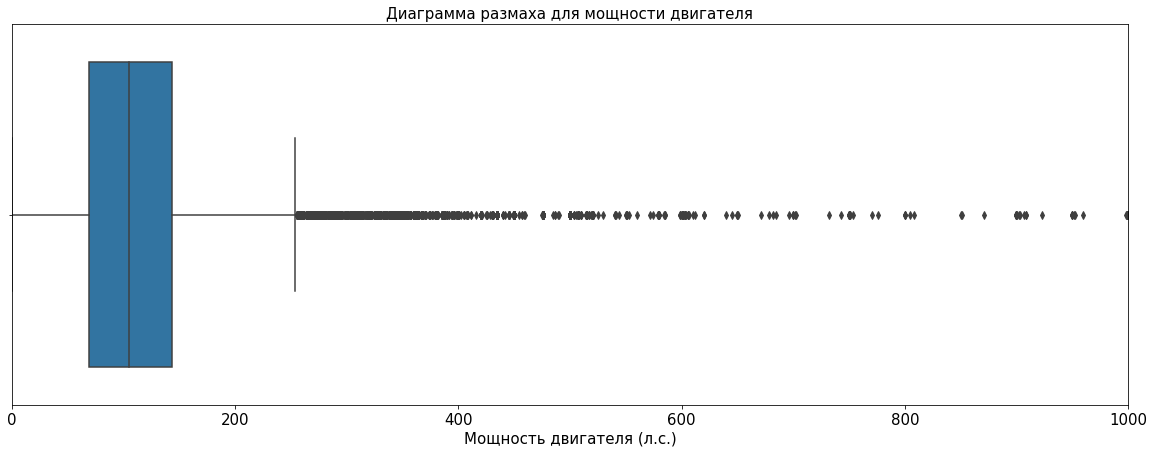

In [16]:
plt.figure(figsize=(20, 7))
plt.xlim(0, 1000)
sns.boxplot(data['power']).tick_params(labelsize=15)
plt.title('Диаграмма размаха для мощности двигателя', fontsize=15)
plt.xlabel('Мощность двигателя (л.с.)', fontsize=15);

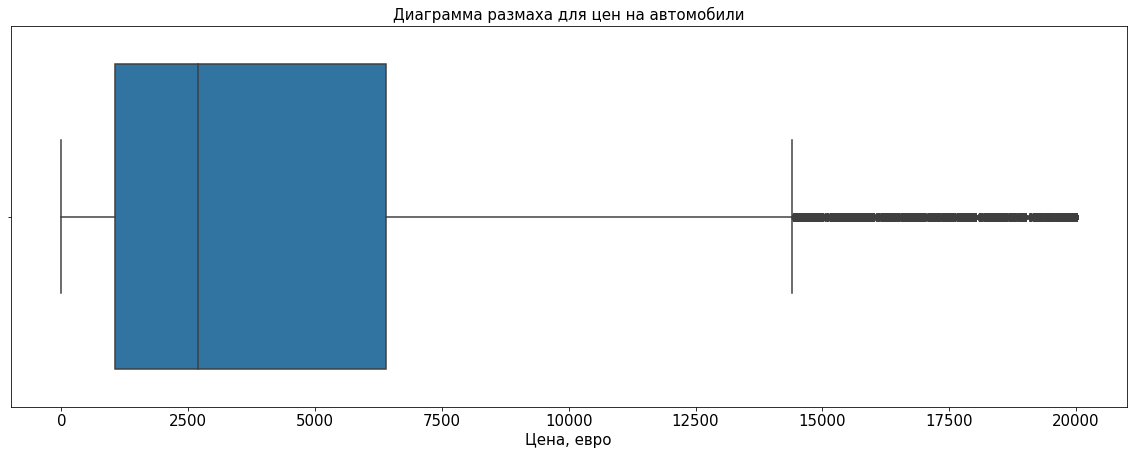

In [17]:
plt.figure(figsize=(20, 7))
sns.boxplot(data['price']).tick_params(labelsize=15)
plt.title('Диаграмма размаха для цен на автомобили', fontsize=15)
plt.xlabel('Цена, евро', fontsize=15);

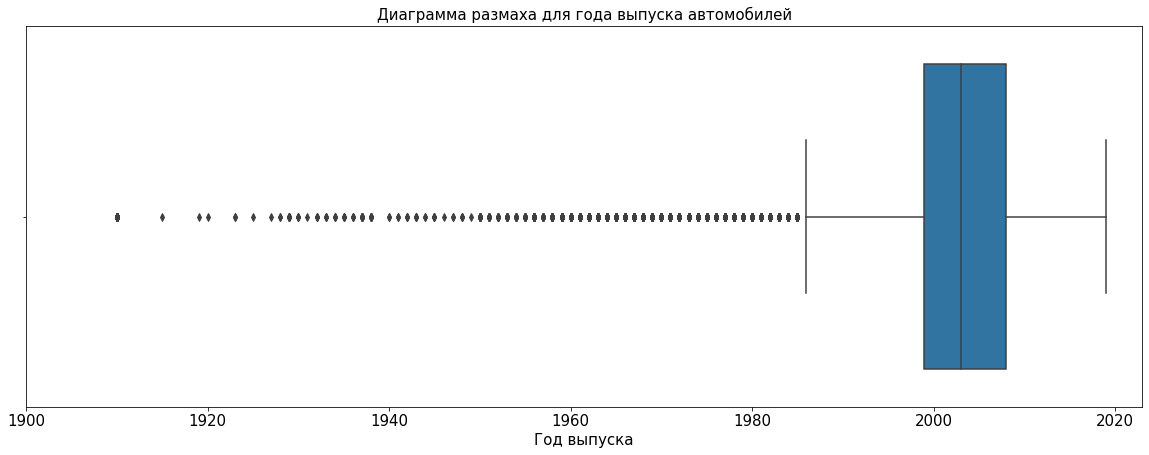

In [18]:
plt.figure(figsize=(20, 7))
plt.xlim(1900, 2023)
sns.boxplot(data['registration_year']).tick_params(labelsize=15)
plt.title('Диаграмма размаха для года выпуска автомобилей', fontsize=15)
plt.xlabel('Год выпуска', fontsize=15);

Делаем выводы:
* На диаграмме размаха выбросами считаются машины мощнее ~270 л.с.. Обрежем выбросы, но по более высокой границе, оставим машины до 400 л.с., так как мощные машины интересуют достаточно большое кол-во людей.
* На диаграмме цен выбросами отображаются машины дороже 14000. Оставим объекты ценой до 14000, так как выбросы в целевом признаке нам ни к чему.
* На диаграмме годов выбросами считаются автомобили старше 1985 года. Оставим объекты младше 1985 года, более старые машины уже редко используются именно как средство передвижения, их покупают скорее для коллекции.

In [19]:
data = data.query('price > 0 and price < 14000')
data = data.query('power > 0 and power < 400')
data = data.query('registration_year >= 1985')

Посмотрим на гистограммы данных после удаления выбросов и ошибочных данных:

Text(0.5, 0.95, 'Гистограммы числовых признаков после удаления выбросов и ошибочных данных')

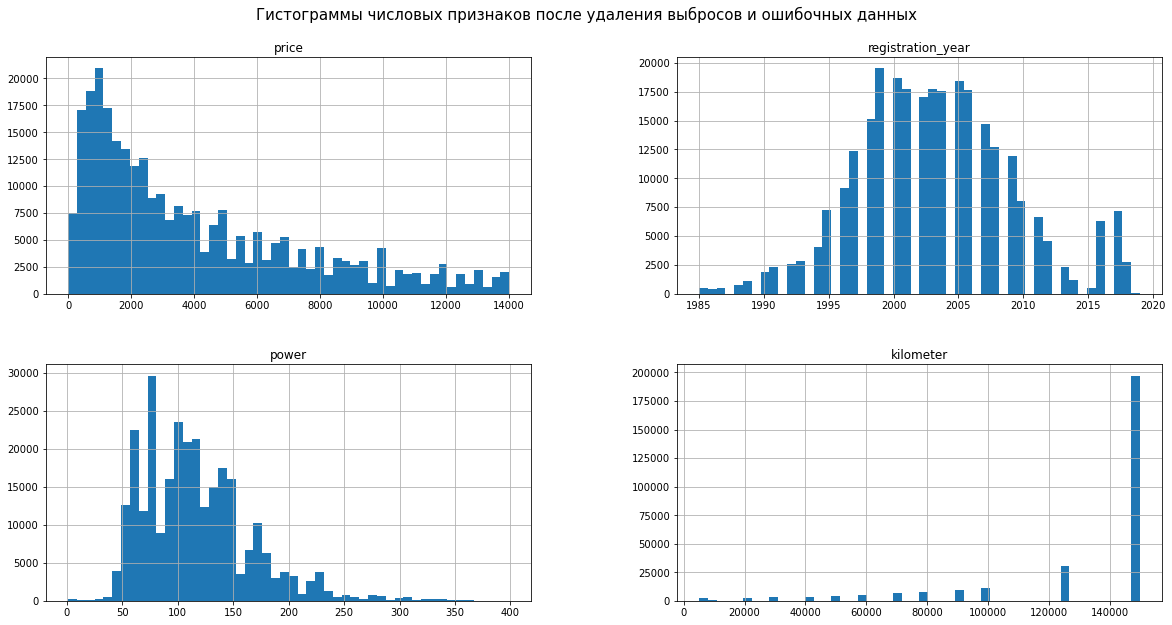

In [20]:
data.hist(bins=50, figsize=(20, 10))
plt.suptitle('Гистограммы числовых признаков после удаления выбросов и ошибочных данных', fontsize=15, y=0.95)

В целом, распределения выглядят нормально.

### Пропуски в данных

Посмотрим на пропуски в данных:

In [21]:
data.isna().sum()

price                    0
vehicle_type         20689
registration_year        0
gearbox               5812
power                    0
model                11360
kilometer                0
fuel_type            19025
brand                    0
repaired             45132
dtype: int64

Как мы видим, пропуски есть только в категориальных столбцах. Таким образом, можем заполнить их заглушкой `'unknown'`

In [22]:
data = data.fillna('unknown')
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

### Разделение на выборки

Разделим данные на выборки в соотношении 4:1. Валидационные выборки не понадобятся, так как мы будем делать кросс-валидацию.

In [23]:
features = data.drop('price', axis=1)
target = data['price']

In [24]:
train_features, test_features, train_target, test_target = \
        train_test_split(features, target, test_size=0.2, random_state=RANDOM_STATE)

### Кодирование через `OneHotEncoder()`

Закодируем категориальные признаки через OHE:

In [25]:
encoder = OneHotEncoder(sparse=False, drop='first')
encoder.fit(train_features[cat])

def ohe(data):
    data_ohe = encoder.transform(data[cat])
    data_ohe = pd.DataFrame(data_ohe, columns=encoder.get_feature_names())
    data.reset_index(drop=True, inplace=True) 
    data_coded = pd.DataFrame()
    data_coded[encoder.get_feature_names()] = data_ohe
    data_coded[num] = data[num]
    return data_coded

train_features_ohe = ohe(train_features)
test_features_ohe = ohe(test_features)

display(train_features.sample(3, random_state=RANDOM_STATE))
display(train_features_ohe.sample(3, random_state=RANDOM_STATE))

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
223619,sedan,2003,auto,143,c_klasse,150000,gasoline,mercedes_benz,no
5871,sedan,2008,auto,114,golf,150000,gasoline,volkswagen,unknown
28729,small,2001,manual,58,twingo,150000,petrol,renault,no


,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_unknown,x0_wagon,x1_1986,x1_1987,...,x5_subaru,x5_suzuki,x5_toyota,x5_trabant,x5_volkswagen,x5_volvo,x6_unknown,x6_yes,power,kilometer
223619,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143,150000
5871,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,114,150000
28729,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58,150000


Проверим, чтобы в закодированных данных не было пропусков:

In [26]:
print(train_features_ohe.isna().sum().sum())
print(test_features_ohe.isna().sum().sum())

0
0


Всё в порядке, можем двигаться дальше.

### Стандартизация непрерывных признаков

Стандартизируем числовые признаки. Обучим скейлер на тренировочных данных и применим его к тренировочным и тестовым данным:

In [27]:
scaler = StandardScaler()
scaler.fit(train_features[num])

train_features[num] = scaler.transform(train_features[num])
test_features[num] = scaler.transform(test_features[num])
train_features_ohe[num] = scaler.transform(train_features_ohe[num])
test_features_ohe[num] = scaler.transform(test_features_ohe[num])

train_features[num].head()

,power,kilometer
0,1.096678,0.548414
1,-0.956275,-1.196772
2,-1.342474,0.548414
3,0.486890,0.548414
4,1.238962,-0.905907


## Обучение моделей

Напишем функцию для RMSE, чтобы сделать из неё собственную метрику для `GridSearchCV`.

In [28]:
def rmse(predict, target):
    return mean_squared_error(predict, target, squared=False)
rmse_scorer = make_scorer(rmse, greater_is_better=False)

Обучим три модели: бустинг от LightGBM, линейную реггрессию и случайное дерево. Сравним для всех время обучения, время предсказания и качество.

### `LGBMRegressor()`

В LGBMRegressor передадим незакодированные данные, так как в нём есть встроенный алгоритм кодирования.

In [29]:
def to_cat_type(data):
    for c in data.columns:
        col_type = data[c].dtype
        if col_type == 'object' or col_type.name == 'registration_year':
            data[c] = data[c].astype('category')
    return data

train_features = to_cat_type(train_features)
test_features = to_cat_type(test_features)

In [30]:
%%time
model_lgb = LGBMRegressor()

params = {'n_estimators': np.arange(10, 101, 30), 
          'max_depth': np.arange(2, 53, 5)}
search_lgb = GridSearchCV(model_lgb, params, n_jobs=-1, cv=5, scoring=rmse_scorer)
search_lgb.fit(train_features, train_target);
best_lgb = search_lgb.best_estimator_
search_lgb.best_params_

CPU times: total: 14.8 s
Wall time: 1min 20s


{'max_depth': 17, 'n_estimators': 100}

In [31]:
print('Лучшее значение RMSE для LGBMRegressor:', abs(search_lgb.best_score_))

Лучшее значение RMSE для LGBMRegressor: 1310.5058515389005


### `LinearRegression()`

In [32]:
%%time
model_lr = LinearRegression()
params = {}
search_lr = GridSearchCV(model_lr, params, n_jobs=-1, cv=5, scoring=rmse_scorer)
search_lr.fit(train_features_ohe, train_target)
best_lr = search_lr.best_estimator_
search_lr.best_params_

CPU times: total: 20.2 s
Wall time: 1min 21s


{}

In [33]:
print('Лучшее значение RMSE для линейной регрессии:', abs(search_lr.best_score_))

Лучшее значение RMSE для линейной регрессии: 1634.199943482975


### `DescisionTreeRegressor()`

In [34]:
%%time
model_tree = DecisionTreeRegressor(random_state=RANDOM_STATE)
params = {'max_depth': np.arange(2, 20, 2)}
search_tree = GridSearchCV(model_tree, params, n_jobs=-1, cv=5, scoring=rmse_scorer)
search_tree.fit(train_features_ohe, train_target)
best_tree = search_tree.best_estimator_
search_tree.best_params_

CPU times: total: 12.1 s
Wall time: 3min 4s


{'max_depth': 18}

In [35]:
print('Лучшее значение RMSE для случайного дерева:', abs(search_tree.best_score_))

Лучшее значение RMSE для случайного дерева: 1567.489069574669


### Анализ времени работы моделей

Измерим время обучения и предсказания моделей с лучшими результатами:

In [36]:
%%time
lgp_pred_time = perf_counter()
best_lgb.predict(train_features)
lgb_pred_time = str(round(perf_counter() - lgp_pred_time, 3)) + 's'

CPU times: total: 3.97 s
Wall time: 669 ms


In [37]:
%%time
lgb_fit_time = perf_counter()
LGBMRegressor(n_estimators=100, max_depth=17).fit(train_features, train_target)
lgb_fit_time = str(round(perf_counter() - lgb_fit_time, 3)) + 's'

CPU times: total: 10.2 s
Wall time: 1.24 s


In [38]:
%%time
lr_pred_time = perf_counter()
best_lr.predict(train_features_ohe)
lr_pred_time = str(round(perf_counter() - lr_pred_time, 3)) + 's'

CPU times: total: 578 ms
Wall time: 196 ms


In [39]:
%%time
lr_fit_time = perf_counter()
LinearRegression().fit(train_features_ohe, train_target)
lr_fit_time = str(round(perf_counter() - lr_fit_time, 3)) + 's'

CPU times: total: 16.7 s
Wall time: 8.49 s


In [40]:
%%time
tree_pred_time = perf_counter()
best_tree.predict(train_features_ohe)
tree_pred_time = str(round(perf_counter() - tree_pred_time, 3)) + 's'

CPU times: total: 312 ms
Wall time: 399 ms


In [41]:
%%time
tree_fit_time = perf_counter()
DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=18).fit(train_features_ohe, train_target)
tree_fit_time = str(round(perf_counter() - tree_fit_time, 3)) + 's'

CPU times: total: 9.91 s
Wall time: 12.5 s


## Анализ моделей

Проверим работу лучшей модели на тестовых данных. Это модель `LGBMRegressor` с параметрами `n_estimators=100` и `max_depth=17`.

In [42]:
%%time
lgb_test_pred_time = perf_counter()
lgb_preds = best_lgb.predict(test_features)
lgb_test_pred_time = str(round(perf_counter() - lgb_test_pred_time, 3)) + 's'
test_lgb_score = rmse(lgb_preds, test_target)
test_lgb_score

CPU times: total: 1.06 s
Wall time: 233 ms


1307.794700824098

Создадим DataFrame, чтобы наглядно сравнить результаты:

In [43]:
results = pd.DataFrame([[abs(search_lgb.best_score_), abs(search_lr.best_score_), abs(search_tree.best_score_)],
                        [test_lgb_score, '-', '-'],
                        [lgb_fit_time, lr_fit_time, tree_fit_time],
                        [lgb_pred_time, lr_pred_time, tree_pred_time],
                        [lgb_test_pred_time, '-', '-']],
                       columns=['LGBMRegressor', 'LinearRegression', 'DescisionTreeRegressor'],
                       index=['rmse_cross_validation', 'rmse_test_sample', 'train_time', 'predict_time', 'predict_time_test_sample'])
results.T

,rmse_cross_validation,rmse_test_sample,train_time,predict_time,predict_time_test_sample
LGBMRegressor,1310.505852,1307.794701,1.242s,0.672s,0.225s
LinearRegression,1634.199943,-,8.489s,0.194s,-
DescisionTreeRegressor,1567.48907,-,12.504s,0.403s,-


### Выводы

* Лучшая модель градиентного бустинга достигла целевой метрики на тестовых данных с большим запасом.
* Модель дерева имеет средние результаты по всем параметрам.
* Линейная регрессия предсказывает быстрее всего, но время обучения на ней сильно хуже.
* Лучшая метрика и время обучения получились на бустинге, однако время предсказания самое большое.